In [1]:
""" Download and import MNIST Dataset """
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


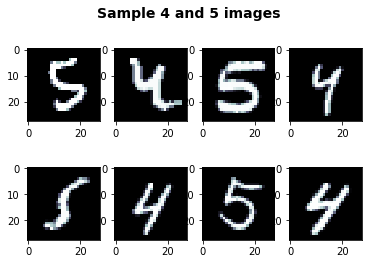

In [2]:
""" Split MNIST Dataset into 4's (large number of data points) and 5's (small number), training, valid, test """
import numpy as np

# 55000 training images of all digits
train_data = mnist.train.images
train_labels = mnist.train.labels
# 10000 test images of all digits
test_data = mnist.test.images
test_labels = mnist.test.labels

# Separate 784-dimensional vectors into 4's and 5's
train_4 = np.array([train_data[i] for i in range(55000) if train_labels[i] == 4])
train_5_expanded = np.array([train_data[i] for i in range(55000) if train_labels[i] == 5])
test_4 = np.array([test_data[i] for i in range(10000) if test_labels[i] == 4])
test_5 = np.array([test_data[i] for i in range(10000) if test_labels[i] == 5])

# Select 50 5's
np.random.seed(123)
np.random.shuffle(train_5_expanded)
train_5 = train_5_expanded[:50,:]

# Get Number of training examples for each
num_train_4 = len(train_4)
num_train_5 = len(train_5)
num_train_5_expanded = len(train_5_expanded)
num_test_4 = len(test_4)
num_test_5 = len(test_5)

""" Plot sample images """
import matplotlib.pyplot as plt
fig, axarr = plt.subplots(2, 4)
for i in range(2):
    for j in [1,3]:
        axarr[i,j].imshow(train_4[j + i * 4].reshape([28,28]), cmap='bone')
        axarr[i,j-1].imshow(train_5[j-1 + i * 4].reshape([28,28]), cmap='bone')
plt.suptitle('Sample 4 and 5 images', fontsize=14, fontweight='bold')
plt.show()

Dataset Maximum: 1.000000
Dataset Minimum: 0.000000
Dataset Mean: 0.121469


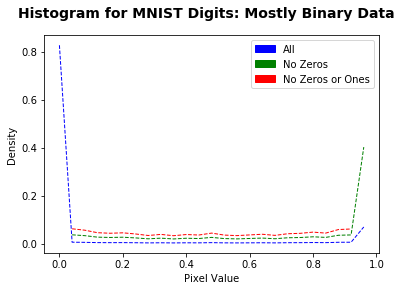

In [3]:
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
train = np.vstack((train_4, train_5))
print("Dataset Maximum: %f" % train.max())
print("Dataset Minimum: %f" % train.min())
print("Dataset Mean: %f" % train.mean())

# Histogram for All Pixels
bins, y = np.histogram(train, bins=25)
bins_all = bins / np.sum(bins)

# Histogram for All Pixels without Zeros
y_no_zero = y[:-1]
bins_no_zero = bins[1:]
bins_no_zero = bins_no_zero / np.sum(bins_no_zero)

# Histogram for All Pixels without Zeros or Ones
y_no_zero_no_one = y_no_zero[:-1]
bins_no_zero_no_one = bins_no_zero[:-1]
bins_no_zero_no_one = bins_no_zero_no_one / np.sum(bins_no_zero_no_one)

# Plot 3 Histograms on same axis
plt.plot(y[:-1], bins_all, 'b--', linewidth=1)
plt.plot(y_no_zero[1:], bins_no_zero, 'g--', linewidth=1)
plt.plot(y_no_zero_no_one[1:], bins_no_zero_no_one, 'r--', linewidth=1)
fours = mpatches.Patch(color='blue', label='All')
no_zero = mpatches.Patch(color='green', label='No Zeros')
no_zero_no_one = mpatches.Patch(color='red', label='No Zeros or Ones')
plt.legend(handles=[fours, no_zero, no_zero_no_one])
plt.suptitle("Histogram for MNIST Digits: Mostly Binary Data", fontsize=14, fontweight='bold')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.show()

In [4]:
""" Remove rows with 0 variance """

# Find indices where variance is 0. i.e. all entries are 0.
idx = np.array([i for i in range(784) if train_4[:,i].var() < 1e-4])
print("Number of covariates removed: %d" % len(idx))
print("Percentage of variates removed: %f" % (len(idx) / 784))

# Delete those rows with variance
train_vectors_4 = np.delete(train_4, idx, axis=1)
train_vectors_5 = np.delete(train_5, idx, axis=1)
train_vectors_5_expanded = np.delete(train_5_expanded, idx, axis=1)
test_vectors_4 = np.delete(test_4, idx, axis=1)
test_vectors_5 = np.delete(test_5, idx, axis=1)

# Combine all train vectors and generate labels
train_vectors = np.vstack((train_vectors_4, train_vectors_5))
train_labels = np.hstack((np.zeros(num_train_4, dtype=np.int32), np.ones(num_train_5, dtype=np.int32)))
test_vectors = np.vstack((test_vectors_4, test_vectors_5))
test_labels = np.hstack((np.zeros(num_test_4, dtype=np.int32), np.ones(num_test_5, dtype=np.int32)))
train_vectors_expanded = np.vstack((train_vectors_4, train_vectors_5_expanded))
train_labels_expanded = np.hstack((np.zeros(num_train_4, dtype=np.int32), np.ones(num_train_5_expanded, dtype=np.int32)))

Number of covariates removed: 240
Percentage of variates removed: 0.306122


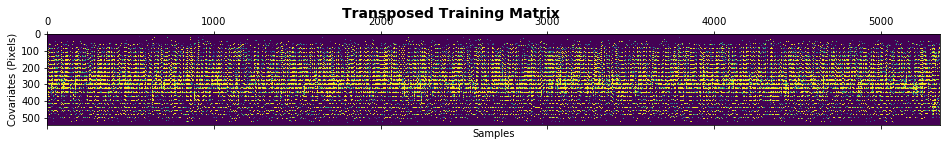

In [5]:
""" Multi-Colinearity Investigation """

# Plot Training Matrix
plt.matshow(train_vectors.T)
plt.suptitle("Transposed Training Matrix", fontsize=14, fontweight='bold')
plt.ylabel('Covariates (Pixels)')
plt.xlabel('Samples')
plt.show()

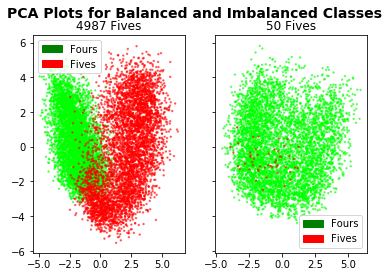

Explained Variance Ratio for First 10 PC's in Imbalanced Class Vector:
[ 0.11772346  0.0951759   0.06761056  0.05681834  0.05011585  0.04300367
  0.03712916  0.03318387  0.02846933  0.02701958]
Difference in Explained Variance Ratio for Balanced and Imbalanced Classes for each PC:
[-0.00187989 -0.00321701  0.00890982  0.01012269  0.01173167  0.00702453
  0.00391246  0.00343128  0.00213533  0.0033632 ]


In [6]:
""" Apply PCA to training and expanded training datasets """
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve

fours = mpatches.Patch(color='green', label='Fours')
fives = mpatches.Patch(color='red', label='Fives')
colors = np.array([[0,1,0],[1,0,0]])
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

pca_exp = PCA(n_components=10)
X_exp = pca_exp.fit_transform(train_vectors_expanded)
ax1.scatter(X_exp[:,0],X_exp[:,1], c=colors[train_labels_expanded], s=2, alpha=0.5)
ax1.legend(handles=[fours, fives])
ax1.set_title('%i Fives' % num_train_5_expanded)

pca = PCA(n_components=10)
X = pca.fit_transform(train_vectors)
ax2.scatter(X[:,0],X[:,1], c=colors[train_labels], s=2, alpha=0.5)
ax2.legend(handles=[fours, fives])
ax2.set_title('%i Fives' % 50)

plt.suptitle('PCA Plots for Balanced and Imbalanced Classes', fontsize=14, fontweight='bold')
plt.show()

print("Explained Variance Ratio for First 10 PC's in Imbalanced Class Vector:")
print(pca.explained_variance_ratio_)

print("Difference in Explained Variance Ratio for Balanced and Imbalanced Classes for each PC:")
print(pca.explained_variance_ratio_ - pca_exp.explained_variance_ratio_)

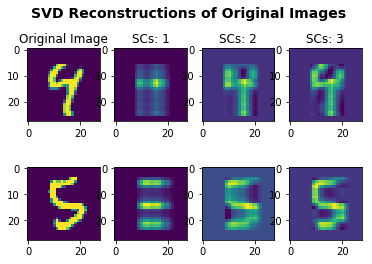

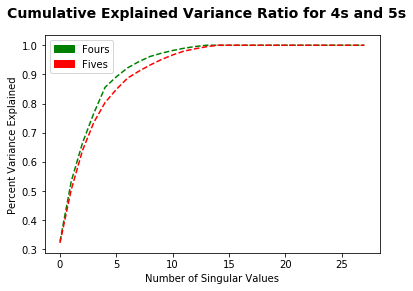

In [7]:
""" Form vectorized data into image (matrix) data and compute SVDs """
# Reshape vectors into 2D Images.
train_images_4 = [i.reshape([28,28]) for i in train_4]
train_images_5 = [i.reshape([28,28]) for i in train_5]
train_images_5_expanded = [i.reshape([28,28]) for i in train_5_expanded]
test_images_4 = [i.reshape([28,28]) for i in test_4]
test_images_5 = [i.reshape([28,28]) for i in test_5]

train_images = np.vstack((train_images_4, train_images_5))
train_images_expanded = np.vstack((train_images_4, train_images_5_expanded))
test_images = np.vstack((test_images_4, test_images_5))

# Define helper functions
def svd_to_image(image, rank):
    U, sigma, V = np.linalg.svd(image)
    img_out = np.matrix(U[:, :rank]) * np.diag(sigma[:rank]) * np.matrix(V[:rank, :])
    return img_out

def svd_to_S(image):
    U, S, V = np.linalg.svd(image)
    return S

def svd_to_vector(image):
    U, S, V = np.linalg.svd(image)
    return np.hstack((U[:,0], U[:,1]))

# Create Representative Images and their corresponding SVDs
imgs = [train_images_4[0], train_images_5[0]]

fig, axarr = plt.subplots(2,4)

axarr[0,0].imshow(imgs[0])
axarr[0,0].set_title('Original Image')
axarr[1,0].imshow(imgs[1])

for r in range(1,4):
    for i in range(2):
        if i == 0:
            axarr[i,r].set_title('SCs: %i' % r)
        axarr[i,r].imshow(svd_to_image(imgs[i], r))
plt.suptitle('SVD Reconstructions of Original Images', fontsize=14, fontweight='bold')
plt.show()

# Plot Singular Values
plt.plot(np.cumsum(svd_to_S(imgs[0])) / np.sum(svd_to_S(imgs[0])), 'g--')
plt.plot(np.cumsum(svd_to_S(imgs[1])) / np.sum(svd_to_S(imgs[1])), 'r--')
fours = mpatches.Patch(color='green', label='Fours')
fives = mpatches.Patch(color='red', label='Fives')
plt.legend(handles=[fours, fives])
plt.suptitle('Cumulative Explained Variance Ratio for 4s and 5s', fontsize=14, fontweight='bold')
plt.xlabel('Number of Singular Values')
plt.ylabel('Percent Variance Explained')
plt.show()

# Create new vectors from SVD components
train_vectors_svd = list()
for image in train_images:
    vector = svd_to_vector(image)
    train_vectors_svd.append(vector)
train_vectors_svd = np.array(train_vectors_svd)
    
train_vectors_svd_expanded = list()
for image in train_images_expanded:
    vector = svd_to_vector(image)
    train_vectors_svd_expanded.append(vector)
train_vectors_svd_expanded = np.array(train_vectors_svd_expanded)

test_vectors_svd = list()
for image in test_images:
    vector = svd_to_vector(image)
    test_vectors_svd.append(vector)
test_vectors_svd = np.array(test_vectors_svd)

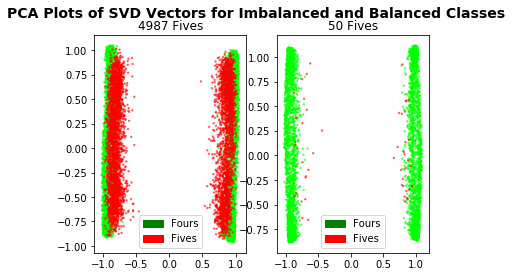

Explained Variance Ratio for First 10 PC's in Imbalanced Class Vector:
[ 0.45838338  0.25477767  0.10640867  0.05314032  0.02304041  0.01628329
  0.01490135  0.01137692  0.01064984  0.00677507]
AUC for SVD-PCA method, threshold of 0.82: 0.866246
AUC for SVD-PCA method, threshold of 0.88: 0.902704
AUC for SVD-PCA method, threshold of 0.94: 0.896920


In [8]:
""" Apply PCA to SVD Vectors """
fig, (ax1 ,ax2) = plt.subplots(1,2)

pca_exp = PCA(n_components=10)
X_exp = pca_exp.fit_transform(train_vectors_svd_expanded)
ax1.scatter(X_exp[:,0],X_exp[:,1], c=colors[train_labels_expanded], s=2, alpha=0.5)
ax1.legend(handles=[fours, fives])
ax1.set_title('%i Fives' % num_train_5_expanded)

pca = PCA(n_components=10)
X = pca.fit_transform(train_vectors_svd)
ax2.scatter(X[:,0],X[:,1], c=colors[train_labels], s=2, alpha=0.5)
ax2.legend(handles=[fours, fives])
ax2.set_title('%i Fives' % 50)

plt.suptitle('PCA Plots of SVD Vectors for Imbalanced and Balanced Classes', fontsize=14, fontweight='bold')
plt.show()

print("Explained Variance Ratio for First 10 PC's in Imbalanced Class Vector:")
print(pca.explained_variance_ratio_)

""" Create Classifier """
from sklearn.metrics import roc_curve, roc_auc_score

pca_train = pca.fit(train_vectors_svd)
X_test = pca_train.transform(test_vectors_svd)[:,0]
pred_labels = [1 if abs(x) < 0.84 else 0 for x in X_test]
print('AUC for SVD-PCA method, threshold of 0.82: %f' % roc_auc_score(test_labels, pred_labels))
pred_labels = [1 if abs(x) < 0.88 else 0 for x in X_test]
print('AUC for SVD-PCA method, threshold of 0.88: %f' % roc_auc_score(test_labels, pred_labels))
pred_labels = [1 if abs(x) < 0.90 else 0 for x in X_test]
print('AUC for SVD-PCA method, threshold of 0.94: %f' % roc_auc_score(test_labels, pred_labels))

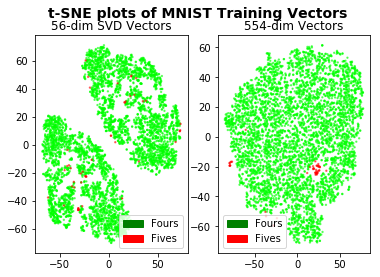

In [9]:
""" Run t-SNE Visualizations"""
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
X_tsne = tsne.fit_transform(train_vectors) 

tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
tsne_fit_svd = tsne.fit_transform(train_vectors_svd)

fig, (ax1 ,ax2) = plt.subplots(1,2)

ax1.scatter(tsne_fit_svd[:,0],tsne_fit_svd[:,1], c=colors[train_labels_expanded], s=2, alpha=0.5)
ax1.legend(handles=[fours, fives])
ax1.set_title('56-dim SVD Vectors')

ax2.scatter(X_tsne[:,0],X_tsne[:,1], c=colors[train_labels], s=2, alpha=0.5)
ax2.legend(handles=[fours, fives])
ax2.set_title('554-dim Vectors')

plt.suptitle('t-SNE plots of MNIST Training Vectors', fontsize=14, fontweight='bold')
plt.show()